In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pysankey import sankey
from scipy.stats import fisher_exact, mannwhitneyu
import numpy as np

url_prefix='https://static.94.87.140.128.clients.your-server.de/icfxapi/'
url_icf = url_prefix+'icfdata/'
url_users=url_prefix+'users/'
url_def_prefix = 'http://icfx-ressources.renecol.org/'
url_whodas_def = 'whodas12_de.json'
url_sf36_categories_def = 'sf36_categories_de.json'
url_sf36_def = 'sf36_de.json'
url_env_def = 'env_factors_de.json'
token = 'ZsDvj7BXJTmd7M0pVPwN60Fyu7l9VQ'

# Requests
r = requests.get(url_icf, headers={'Authorization': 'Bearer '+token}).json()
r2 = requests.get(url_users, headers={'Authorization': 'Bearer '+token}).json()
# get labels from definition file
r3 = requests.get(url_def_prefix+url_whodas_def).json()
r4 = requests.get(url_def_prefix+url_sf36_categories_def).json()
r5 = requests.get(url_def_prefix+url_sf36_def).json()
r6 = requests.get(url_def_prefix+url_env_def).json()
# ICF Definitionen holen
url_icf_def = 'icf_codes3.json'
r7 = requests.get(url_def_prefix + url_icf_def).json()

# Nur Patientendaten extrahieren
df=pd.DataFrame(r).drop(columns=['owner_institution'])

df_selected_patients = pd.read_excel('raupennest/raupennest_population_with_pseudonym-2.xlsx')
# filter df to include only owner == uuid in df_selected_patients['uuid']
df2 = df[df['owner'].isin(df_selected_patients['uuid'])]
print('Anzahl Patienten nach Filterung auf Raupennest Population: %i'%(df2['owner'].nunique()))
df2.to_pickle('raupennest/icf_data_raupennest_all.pkl')
df2.to_excel('raupennest/icf_data_raupennest_all.xlsx')

In [12]:

df_patients=df2[df2['owner']==df2['creator']]

# now expand the data column
df_patients=pd.concat([df_patients,df_patients['data'].apply(pd.Series)], axis=1)
df_patients=df_patients[df_patients['icf']!={}]

In [13]:
df_sf36=df_patients['sf36'].apply(pd.Series).dropna()
def sf36_normalizer(s):
    key = s.name
    n_possibleAnswers = len(r5[key]['answers'])
    defaultAnswer = r5[key]['default']
    base100_factor = 100/n_possibleAnswers
    if defaultAnswer == n_possibleAnswers-1:
        # ascending scale -> best possible result is highest score
        return base100_factor*(s+1)
    else:
        # descending scale
        return base100_factor*(n_possibleAnswers-s)

    
df_sf36_n=df_sf36.apply(sf36_normalizer)
df_sf36_definitions = pd.DataFrame(r5)
df_sf36_grouped = pd.DataFrame(index=df_sf36.index)
for group in r4:
    print(group['keys'])
    df_sf36_grouped[group['abbr']]=df_sf36_n[group['keys']].mean(axis=1)
cat_descriptions = {item['abbr']:item['title']+'(SF36)' for item in r4}
df_sf36_grouped2 = df_sf36_grouped.rename(columns=cat_descriptions)

['Q3a', 'Q3b', 'Q3c', 'Q3d', 'Q3e', 'Q3f', 'Q3g', 'Q3h', 'Q3i', 'Q3j']
['Q4a', 'Q4b', 'Q4c', 'Q4d']
['Q7', 'Q8']
['Q1', 'Q11a', 'Q11b', 'Q11c', 'Q11d']
['Q9a', 'Q9e', 'Q9g', 'Q9i']
['Q6', 'Q10']
['Q5a', 'Q5b', 'Q5c']
['Q9b', 'Q9c', 'Q9d', 'Q9f', 'Q9h']
['Q2']
['Q1']


# Screening ENV

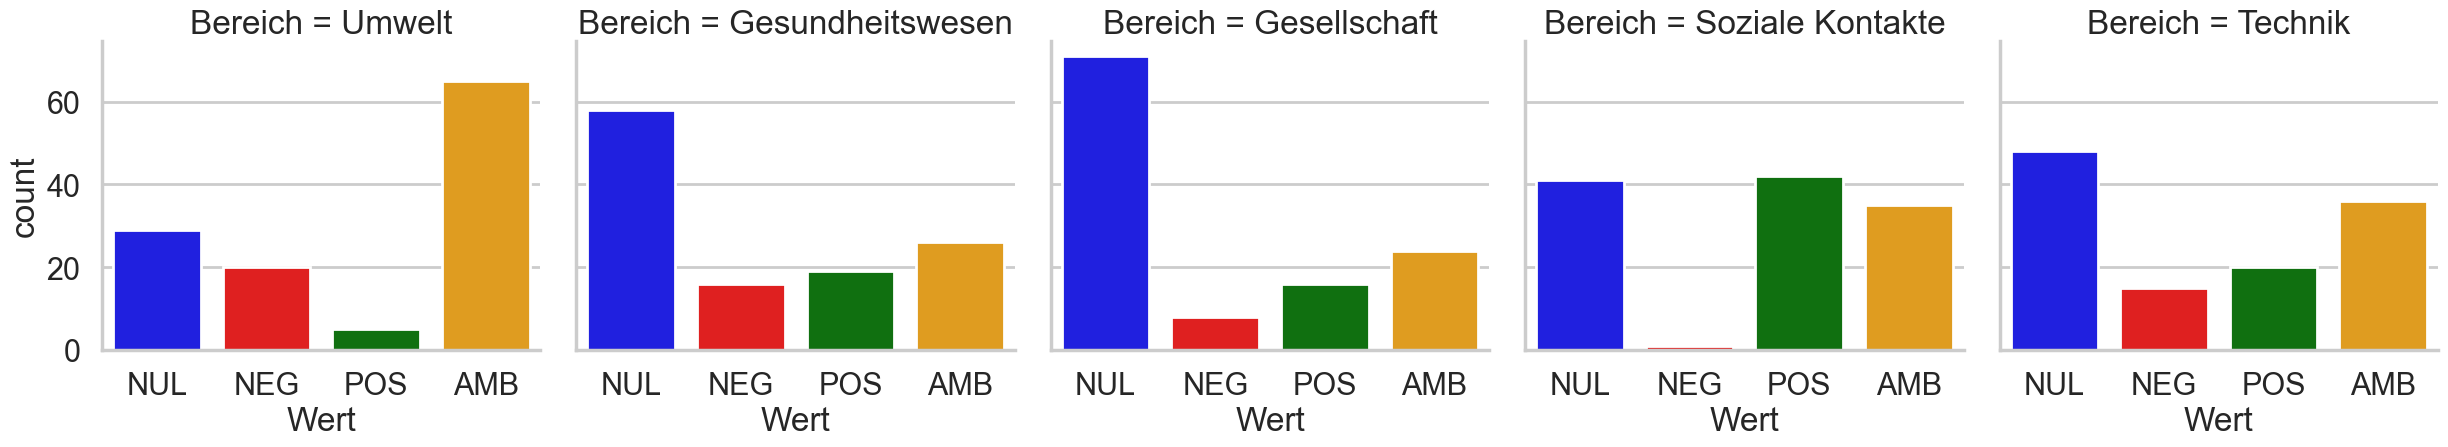

In [82]:
df_env=df_patients['env'].apply(pd.Series)
df_env=df_env.dropna().astype(int)
df_env=df_env.rename(columns=lambda x: r6[x]['s'])
env_options = {5:
  {"name": 'positiv (gut)', "key":"POS"}, 9: {
    "name": 'positiv und negativ (zugleich gut und schlecht)',
    "key":"AMB"
  }, 3: {"name": 'negativ (schlecht)',"key":"NEG"}, 4:{"name": 'gar nicht', "key":"NUL"}
               }
df_env_enc = df_env.applymap(lambda x: env_options[x]['key'])
df_env_enc_long=pd.melt(df_env_enc,  var_name='Bereich',
                   value_name='Wert')

sns.set_context("poster")
palette = {
        'NUL': 'blue',
        'NEG': 'red',
        'POS': 'green',
        'AMB': 'orange'
    }
g=sns.catplot(df_env_enc_long, kind='count', x='Wert', col='Bereich', order=['NUL','NEG','POS','AMB'], hue='Wert', palette=palette, legend=False)
g.savefig('output/env-barplot-v3.jpg', dpi=600)

In [85]:
df_env_enc_long.groupby('Bereich').value_counts(normalize=True)

Bereich           Wert
Gesellschaft      NUL     0.596639
                  AMB     0.201681
                  POS     0.134454
                  NEG     0.067227
Gesundheitswesen  NUL     0.487395
                  AMB     0.218487
                  POS     0.159664
                  NEG     0.134454
Soziale Kontakte  POS     0.352941
                  NUL     0.344538
                  AMB     0.294118
                  NEG     0.008403
Technik           NUL     0.403361
                  AMB     0.302521
                  POS     0.168067
                  NEG     0.126050
Umwelt            AMB     0.546218
                  NUL     0.243697
                  NEG     0.168067
                  POS     0.042017
Name: proportion, dtype: float64

# Erzeugung ICF
## Extraktion der realen ICF Daten (vom Patienten nachbearbeitet)
Es werden zuerst die auswertbaren Datensätze ausgewählt.

In [211]:
# icf datapart
def flipNumber(n, center=4):
    if n<center:
        return center+(center-n)
    if n>center:
        return center-(n-center)
    return n

def explode_icf_column(d, exclude_defaults=True, flip=True):
    t = {}
    for k, v in d.items():
        if v['selected'] == 1:
            va=v['value']
            # wenn es sich hier um Kapitel e handelt, müssen die Werte noch gespiegelt werden, damit sie in die gleiche Richtung zeigen. Hohe Werte = hohe Beeinträchtigung
            # cave nur für den Vergleich mit WHODAS, ansonsten anders herum
            if k[0]=='e':
                if va!=4: # exclude default vals
                    if flip:
                        t[k] = flipNumber(v['value']) # flip 
                    else:
                        t[k] = v['value']
                if not exclude_defaults:
                    if flip:
                        t[k] = flipNumber(v['value']) # flip 
                    else:
                        t[k] = v['value']
            else:
                if va>0: # exclude default vals
                    t[k] = va
    return t

df_patients['icfvals'] = df_patients['icf'].apply(lambda x: explode_icf_column(x,exclude_defaults=True, flip=False))
df_patients['n_icf'] = df_patients['icfvals'].apply(lambda x: len(x))

In [212]:
df_patients['n_whodas']= df_patients['whodas'].apply(lambda x: len(x))
df_patients['n_sf36']= df_patients['sf36'].apply(lambda x: len(x))
mask1 = df_patients['n_icf']>0  
mask2=df_patients['n_whodas']>0 
mask3=df_patients['n_sf36']>0
df_final = df_patients.loc[mask1].loc[mask2].loc[mask3]
print('Auswertbare Daten: %i'%len(df_final))

Auswertbare Daten: 112


## Abbildung der Umweltfaktoren auf ICF Skala
Die Umweltfaktoren werden auf die normierte (0-100) ICF Skala abgebildet, um eine gemeinsame Visualisierung zu ermöglichen.

In [215]:
def renameColumnIcf(c):
    return r7[c]['t']+'('+c+')'

df_icf=df_final['icfvals'].apply(pd.Series)
# normalize envs
df_icf_env_n = df_icf*(100/8)

In [24]:
all_icfs = []
for i in range(1,6):
    a=r6[str(i)]['l'].split(',')
    for item in a:
        if len(item)>2:
            all_icfs.append(item)
            

I: 1
I: 2
I: 3
I: 4
I: 5


In [216]:
df_icf_a = df_icf_env_n.loc[:,all_icfs].rename(columns={c: renameColumnIcf(c) for c in all_icfs})
df_all=pd.concat([df_icf_a,df_env_enc],axis=1)
df_all_long=pd.melt(df_icf_a, var_name='ICF',value_name='Wert').dropna()

In [217]:
# use regex to extract the ICF Item code which is enclosed in parentheses
df_all_long['ICF_Code'] = df_all_long['ICF'].str.extract(r'\((e\d{3})\)')
# define another column that uses the ICF code to get the description containing chapter from r6[chapter][l] where l contains the ICF code
def get_icf_chapter(icf_code):
    for i in range(1,6):
        if icf_code in r6[str(i)]['l'].split(','):
            return r6[str(i)]['s']
    return 'Unknown'    
df_all_long['Chapter'] = df_all_long['ICF_Code'].apply(get_icf_chapter)

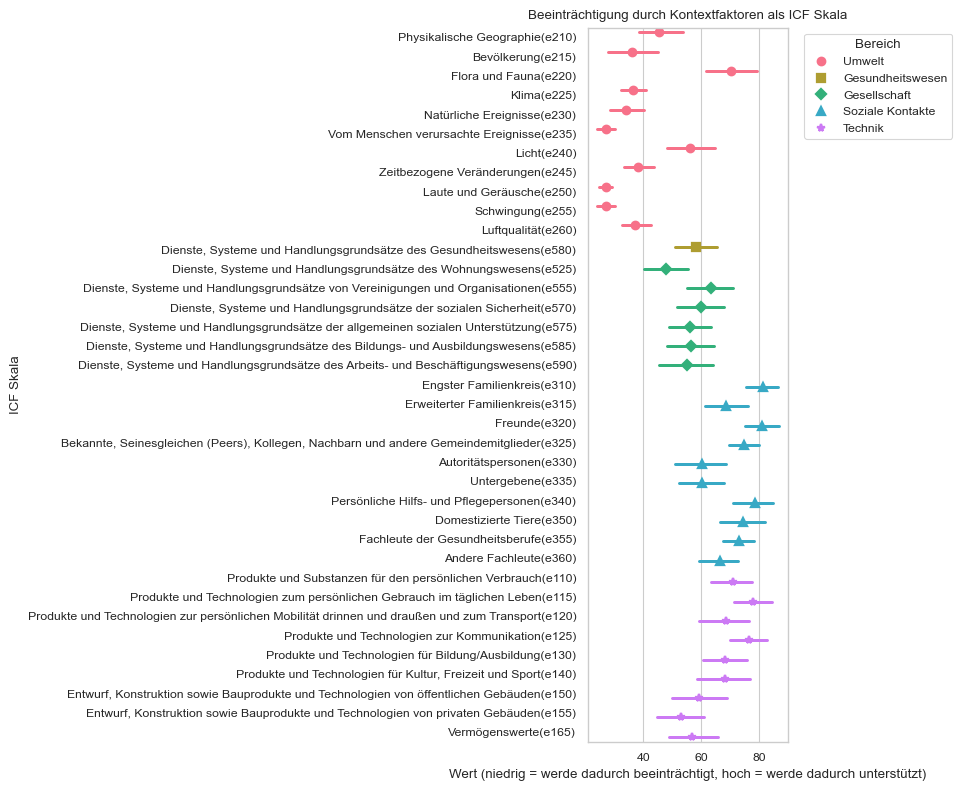

In [219]:
# make a pointplot with seaborn with error bars showing the confidence interval where x=Wert, y=ICF, hue=Chapter, but hue is shown as background color of the points
sns.set_context('paper')
plt.figure(figsize=(10,8))  
sns.pointplot(data=df_all_long, x='Wert', y='ICF', hue='Chapter',
              errorbar='ci', orient='h', dodge=0.5, 
                palette='husl',
    markers=['o', 's', 'D', '^','*'],  # verschiedene Marker pro hue
      linestyle='none' )
plt.title('Beeinträchtigung durch Kontextfaktoren als ICF Skala')
plt.xlabel('Wert (niedrig = werde dadurch beeinträchtigt, hoch = werde dadurch unterstützt)')
plt.ylabel('ICF Skala')
plt.legend(title='Bereich', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('output/icf-umwelt-pointplot-v3.jpg', dpi=600)
plt.show()

In [220]:
# get statistics for all ICFs grouped by Chapter, order by Chapter as in r6
df_all_long.groupby('Chapter')['Wert'].describe().sort_index(key=lambda x: x.map({'Umwelt':1,'Gesundheitswesen':2,'Gesellschaft':3,'Soziale Kontakte':4,'Technik':5}))



,count,mean,std,min,25%,50%,75%,max
Chapter,,,,,,,,
Umwelt,533.0,38.789869,23.381117,0.0,25.0,37.5,37.50,100.0
Gesundheitswesen,47.0,58.244681,25.574459,0.0,37.5,62.5,81.25,100.0
Gesellschaft,158.0,57.199367,22.320333,0.0,37.5,62.5,75.00,100.0
Soziale Kontakte,437.0,72.940503,24.155291,0.0,62.5,75.0,87.50,100.0
Technik,341.0,67.558651,26.500490,0.0,37.5,75.0,87.50,100.0


In [29]:
import numpy as np

def ci_low(series):
    n = series.count()
    if n > 1:
        return series.mean() - 1.96 * series.std() / np.sqrt(n)
    return np.nan

def ci_high(series):
    n = series.count()
    if n > 1:
        return series.mean() + 1.96 * series.std() / np.sqrt(n)
    return np.nan

result = (
    df_all_long
    .groupby('Chapter')['Wert']
    .agg(count='count', mean='mean', ci_low=ci_low, ci_high=ci_high)
    .reset_index()
    .sort_values('Chapter', key=lambda x: x.map({'Umwelt':1,'Gesundheitswesen':2,'Gesellschaft':3,'Soziale Kontakte':4,'Technik':5}))
)

result.to_excel('output/icf_umwelt_statistics-v3.xlsx')

# From ENV to ICF
Make synthetic ICF Items from ENV via semantic links -> set to ENV value

In [111]:
# use df_final['env'] -> df_final['synICF']
# r6 {Number: {l: ICF Items comma separated}}

def makeSynICFFromEnv(env):
    icf_record={}
    value_pattern={
        3:{'value':3, 'selected':1},
        4:{'value':4, 'selected':0},
        5:{'value':5, 'selected':1},
        9:{'value':4, 'selected':1}
    }
    for (k,v) in env.items():
        icf_keys=r6[k]['l'].split(',')
        icf_keys=[i for i in icf_keys if len(i)>0]
        icf_record={**icf_record,**{i:value_pattern[v] for i in icf_keys}}
    return icf_record

df_final['synICF']= df_final['env'].apply(makeSynICFFromEnv)
df_final['synICFvals']=df_final['synICF'].apply(lambda x: explode_icf_column(x,exclude_defaults=False, flip=False))
        

In [128]:
# regenerate icfvals but wthout flip to align them to the same direction as env values
df_final['icfvals']=df_final['icf'].apply(lambda x: explode_icf_column(x,exclude_defaults=True, flip=False))
df_final['eICFvals']=df_final['icfvals'].apply(lambda x: dict(filter(lambda d: d[0][0]=='e',x.items())))


In [143]:
# get the trend by diff between eICFval - synICFVal
# make long
df_trend = df_final[['id','owner','synICFvals','eICFvals']]
df_trend_p1 = df_trend['synICFvals'].apply(pd.Series).rename(lambda x: 'S-'+x, axis='columns')
df_trend_p2 = df_trend['eICFvals'].apply(pd.Series).rename(lambda x: 'R-'+x, axis='columns')
df_trend_complete = pd.concat([df_trend[['id','owner']], df_trend_p1,df_trend_p2], axis=1)
df_trend_long=pd.wide_to_long(df_trend_complete,['S','R'],i='id', j='ICF', sep='-',suffix='\w+')
df_trend_long['change']=df_trend_long['R']-df_trend_long['S']
df_trend_long['Item_discarded']=df_trend_long.apply(lambda x: np.isnan(x['R']), axis=1)
df_trend_long.reset_index(inplace=True)

In [144]:
def reducedAmbiguity(x):
    start = x['S']
    end = x['R']
    if (start==4) & (end!=start):
        return True
    else:
        return False
    
df_trend_long['Ambiguity_reduced']=df_trend_long.apply(reducedAmbiguity,axis=1)

<Axes: xlabel='value', ylabel='Count'>

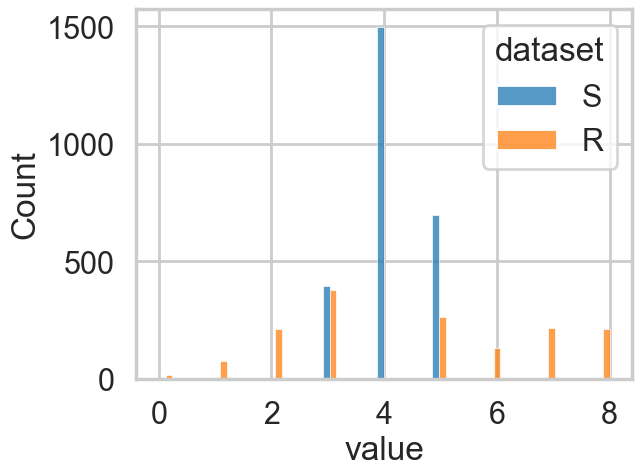

In [131]:
df_trend_distribution=pd.melt(df_trend_long[['ICF','id','S','R']], var_name='dataset', id_vars=['ICF','id'])
sns.histplot(df_trend_distribution,x='value',hue='dataset',multiple='dodge')


Anhand dieser Grafik zeigt sich, dass Patienten aus dem Screening-Datensatz (S) hin zum realen Datensatz (R) durchaus konkretisieren. Der Wert um 4 charakterisiert Ambiguität. Diese wird nun weiter untersucht.

In [145]:
def backtranslateICFToEnvChapter(icf):
    for e in r6.values():
        if icf in e['l']:
            return e['s']

df_trend_long['chapter']=df_trend_long['ICF'].apply(backtranslateICFToEnvChapter)

In [133]:
# eval change. Negative numbers mean, patients have made things worse
df_trend_long.groupby(['chapter']).mean(numeric_only=True)

,id,S,R,change,Item_discarded,Ambiguity_reduced
chapter,,,,,,
Gesellschaft,790.508929,4.130435,4.575949,0.468354,0.764881,0.214286
Gesundheitswesen,790.508929,4.053571,4.659574,0.510638,0.580357,0.223214
Soziale Kontakte,790.508929,4.527027,5.835240,1.148741,0.609821,0.294643
Technik,790.508929,4.060606,5.404692,1.337243,0.661706,0.303571
Umwelt,790.508929,3.821429,3.103189,-0.619137,0.567370,0.562500


In [191]:
# get statistics for change per chapter
chapters = df_trend_long['chapter'].unique()
results_change = []
for chapter in chapters:
    df_chapter = df_trend_long[df_trend_long['chapter']==chapter]
    # quantitative change
    S_values = df_chapter['S'].dropna()
    R_values = df_chapter['R'].dropna()
    stat, p_value = mannwhitneyu(S_values, R_values, alternative='two-sided')
    mean_S = np.mean(S_values)
    mean_R = np.mean(R_values)
    results_change.append({'chapter':chapter, 'mean_S':mean_S, 'mean_R':mean_R, 'p_value':p_value})

df_results_change = pd.DataFrame(results_change)
df_results_change

,chapter,mean_S,mean_R,p_value
0,Umwelt,3.821429,3.103189,2.704350e-87
1,Soziale Kontakte,4.527027,5.835240,5.682319e-61
2,Gesundheitswesen,4.053571,4.659574,4.094974e-02
3,Gesellschaft,4.130435,4.575949,5.262536e-04
4,Technik,4.060606,5.404692,2.558149e-27


In [249]:
df_results_change.to_excel('output/raupennest/icf-umwelt-change-statistics-v3.xlsx')

In [250]:
df_trend_long.groupby(['chapter','ICF'])[['Item_discarded','Ambiguity_reduced']].mean().sort_values(by='Ambiguity_reduced', ascending=False).to_excel('output/raupennest/icf-umwelt-item-statistics-v3.xlsx')

In [146]:
env_options2={0:{'key':'NEG'},1:{'key':'NEG'},2:{'key':'NEG'},3:{'key':'NEG'},4:{'key':'AMB'},5:{'key':'POS'},6:{'key':'POS'},7:{'key':'POS'},8:{'key':'POS'}}
df_trend_long['Origin']=df_trend_long['S'].dropna().map(lambda x: env_options2[x]['key']).fillna('NUL')
df_trend_long['Target']=df_trend_long['R'].dropna().map(lambda x: env_options2[x]['key']).fillna('NUL')

In [147]:
df_trend_long['Origin']=df_trend_long['Origin'].fillna('NUL')
df_trend_long['Target']=df_trend_long['Target'].fillna('NUL')

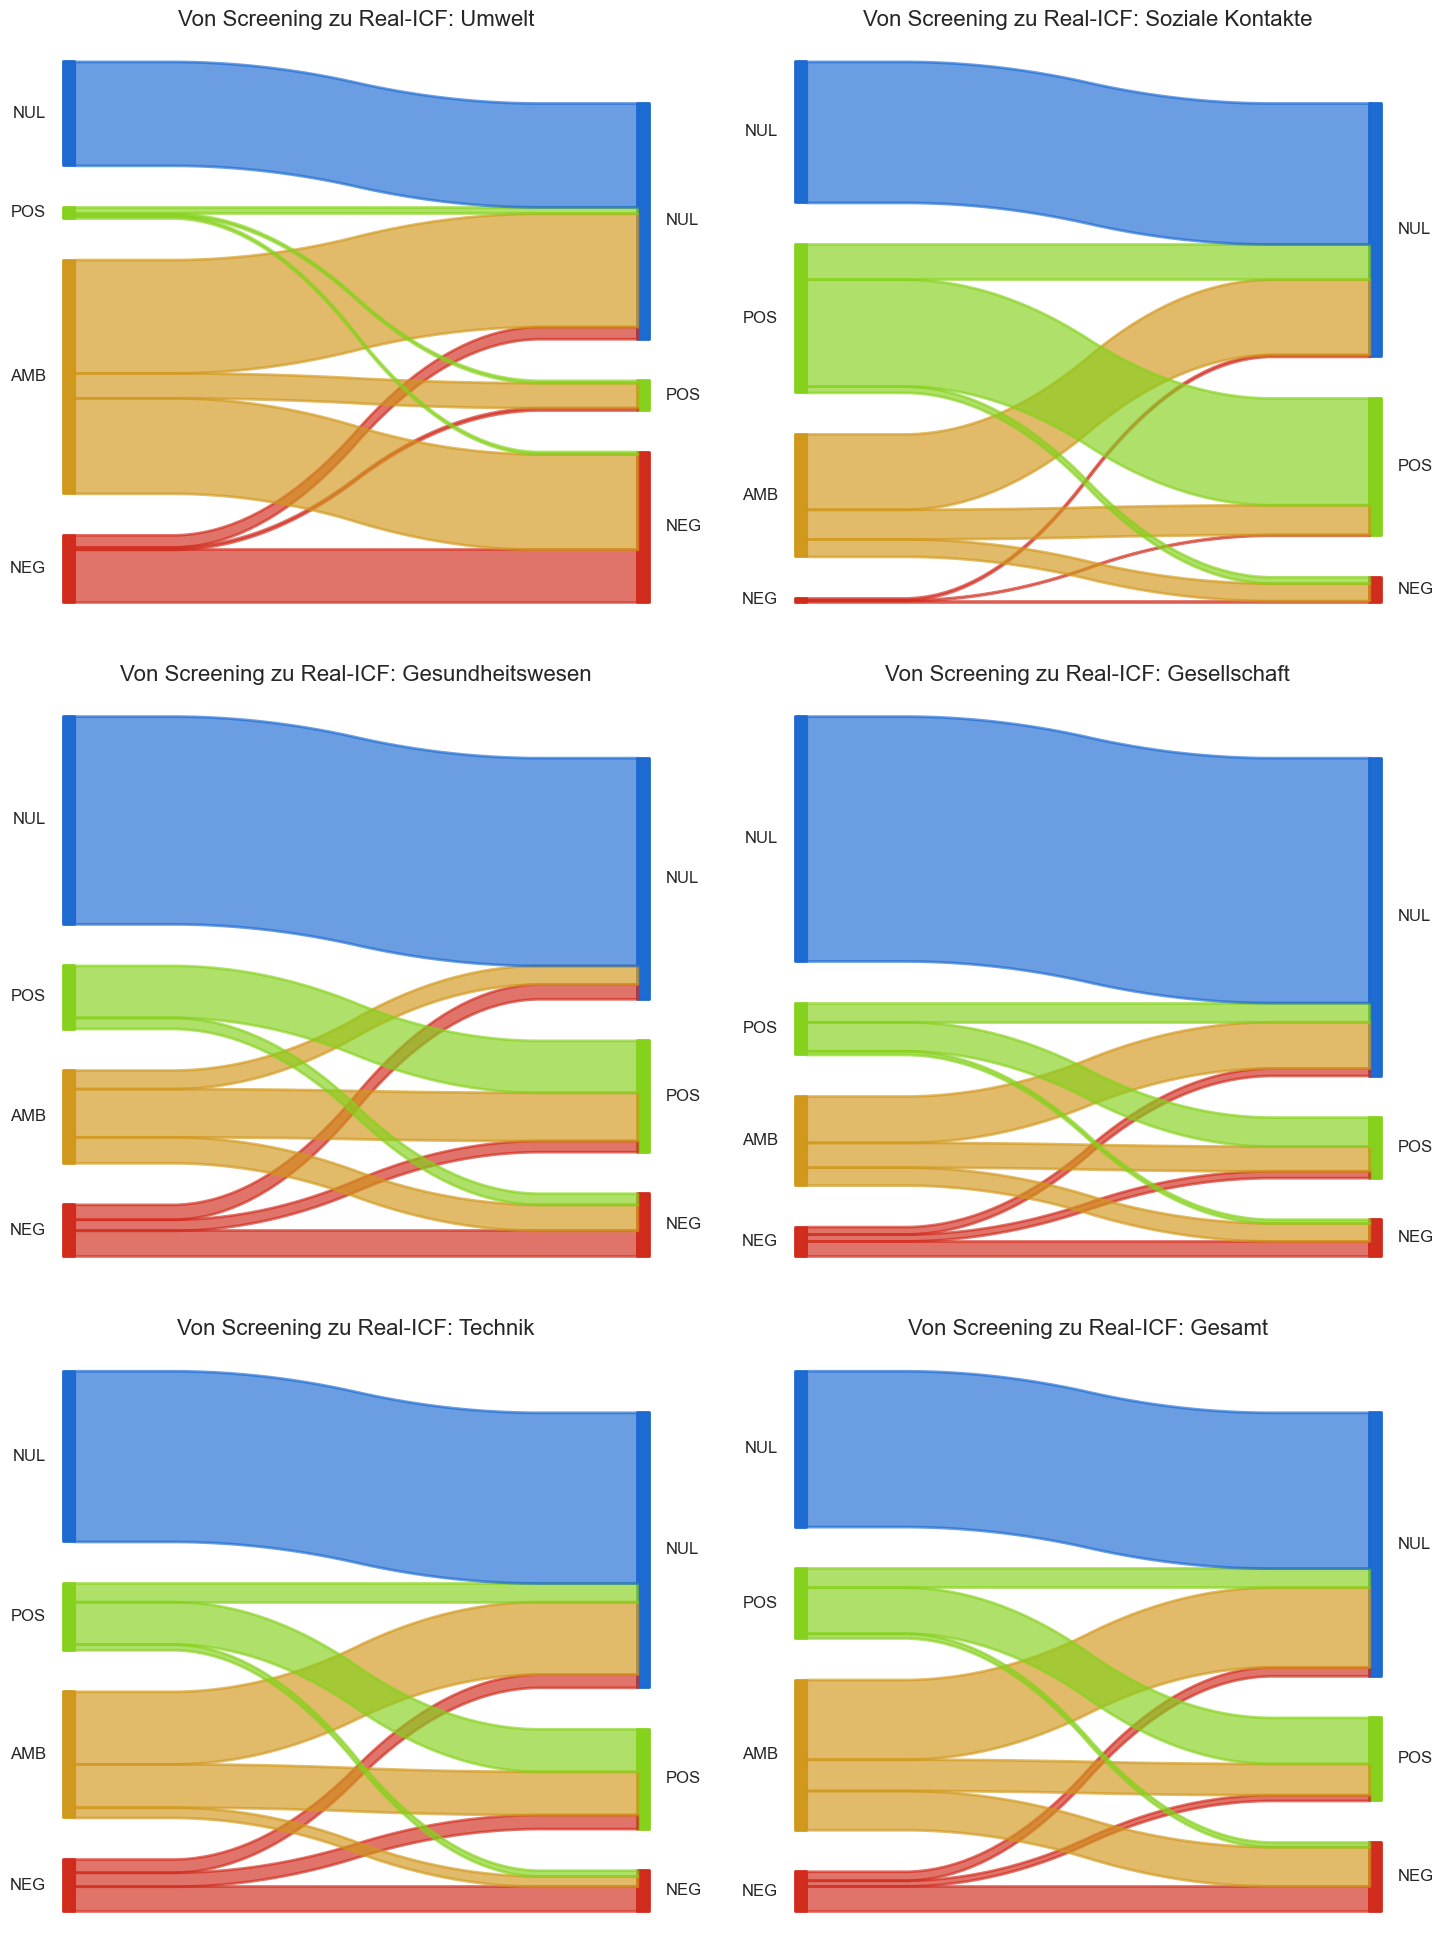

In [137]:
# make sankey plots for each chapter has its own axis and all are shown in one figure

colorDict = {
    'NUL':'#1B69D1',
    'NEG':'#D12A1B',
    'AMB':'#D1971B',
    'POS':'#85D11B'
}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes = axes.flatten()
for i, chapter in enumerate(chapters):
    df_chapter = df_trend_long[df_trend_long['chapter']==chapter]
    ax = sankey(
        df_chapter['Origin'],
        df_chapter['Target'],
        leftLabels=['NEG','AMB','POS','NUL'],
        rightLabels=['NEG','POS','NUL'],
        aspect=20,
        fontsize=12,
        ax=axes[i], colorDict=colorDict)
    ax.set_title('Von Screening zu Real-ICF: %s'%chapter, fontsize=16)

ax=axes[-1]    
ax = sankey(
    df_trend_long['Origin'],
    df_trend_long['Target'],
    leftLabels=['NEG','AMB','POS','NUL'],
    rightLabels=['NEG','POS','NUL'],
    aspect=20,
    fontsize=12, colorDict=colorDict)
ax.set_title('Von Screening zu Real-ICF: Gesamt', fontsize=16)    
plt.tight_layout()
plt.savefig('output/raupennest/icf-umwelt-sankey-all-chapters-v3.jpg', dpi=600)

# Statistische Tests
Es soll untersucht werden, inwiefern
- Wie hoch ist die Wahrscheinlichkeit, dass ein Item discarded wird (discard vs keep, OR)
- Ambiguity reduction (AMB -> POS,NEG; OR)
- wie hoch die Wahrscheinlichkeit ist, dass ein Screening-Item auch als ICF POS oder NEG bleibt (OR)
- wie sich der Schritt von Screening zu ICF (S->R) quantitativ verändert (Means, Mann-Whitney-U)

Dadurch soll ermittelt werden, wie gut der Schritt über ICF zu einer Festigung oder Veränderung der intuitiven Einschätzung führt.

In [148]:
df_trend_long_dummies=pd.get_dummies(df_trend_long, columns=['Origin','Target'])

In [153]:
# calculate statistics per chapter and per Origin_dummy/Target_dummy
results = []
for chapter in chapters:
    df_chapter = df_trend_long_dummies[df_trend_long_dummies['chapter']==chapter]
    for origin in ['Origin_NEG','Origin_POS','Origin_AMB','Origin_NUL']:
        # discarded
        contingency_discarded = pd.crosstab(df_chapter['Item_discarded'], df_chapter[origin])
        oddsratio, p_value = fisher_exact(contingency_discarded)
        results.append({'Question': 'Target_Discarded','chapter':chapter, 'Origin':origin, 'odds_ratio':oddsratio, 'p_value':p_value})
        
        contingency_ambiguity = pd.crosstab(df_chapter['Ambiguity_reduced'], df_chapter[origin])
        oddsratio, p_value = fisher_exact(contingency_ambiguity)
        results.append({'Question': 'Ambiguity_reduced','chapter':chapter, 'Origin':origin, 'odds_ratio':oddsratio, 'p_value':p_value})
        # stability POS/NEG
        for target in ['Target_NEG','Target_POS']:
            df_stability = df_chapter[df_chapter[origin]==1]
            contingency_stability = pd.crosstab(df_stability['Origin_'+origin.split('_')[1]]==df_stability['Target_'+target.split('_')[1]], df_stability[target])
            oddsratio, p_value = fisher_exact(contingency_stability)
            results.append({'Question': 'Stability_'+origin.split('_')[1]+'_'+target.split('_')[1],'chapter':chapter, 'Origin':origin, 'Target':target, 'odds_ratio':oddsratio, 'p_value':p_value})
    # quantitative change

df_results_stats=pd.DataFrame(results)

In [176]:
# calculcate the propability of the occurence of Item_discarded and ambiguity_reduced and pos/neg stability per chapter and per origin

prop_results = []
for chapter in chapters:
    df_chapter = df_trend_long_dummies[df_trend_long_dummies['chapter']==chapter]
    for part in ['NEG','POS','AMB','NUL']:
        origin='Origin_'+part
        df_origin = df_chapter[df_chapter[origin]==1]
        if part!='NUL':
            prop_discarded = df_origin['Item_discarded'].mean()
        if part!='AMB':
            target='Target_'+part
            df_target = df_chapter[df_chapter[target]==1]
            prop_ambiguity = df_target['Ambiguity_reduced'].mean()
        if origin=='Origin_NEG' or origin=='Origin_POS':
            df_stability = df_origin
            prop_stability = (df_stability['Origin_'+origin.split('_')[1]]==df_stability['Target_'+origin.split('_')[1]]).mean()
            prop_results.append({'chapter':chapter, 'value':origin.split('_')[1], 'stability':prop_stability})
        
        prop_results.append({'chapter':chapter, 'value':origin.split('_')[1], 'discarded':prop_discarded, 'disambiguity':prop_ambiguity})
    
df_prop_results = pd.DataFrame(prop_results)

In [177]:
df_prop_long=pd.melt(df_prop_results, id_vars=['chapter','value'], var_name='measure', value_name='proportion').dropna()

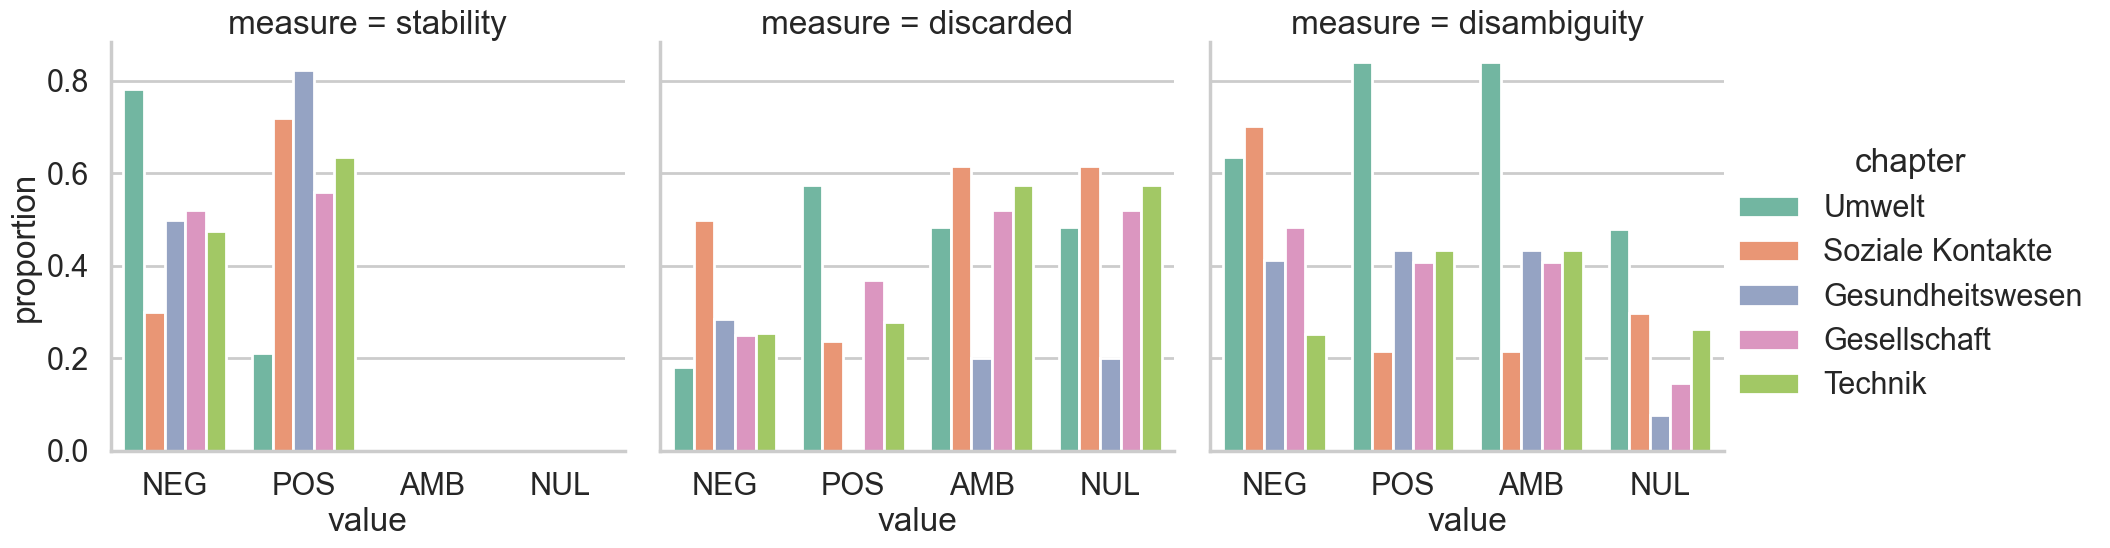

In [178]:
# plot df_prop_long as barplot with seaborn
g=sns.catplot(data=df_prop_long, kind='bar', x='value', y='proportion', col='measure', hue='chapter', palette='Set2', height=6, aspect=1)
g.savefig('output/raupennest/icf-umwelt-prop-barplot-v3.jpg', dpi=600)

<Axes: xlabel='chapter', ylabel='proportion'>

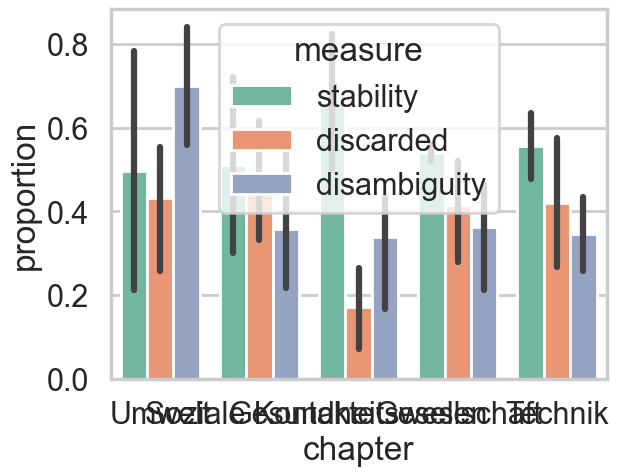

In [181]:
sns.barplot(data=df_prop_long, x='chapter', y='proportion', hue='measure', palette='Set2')

In [184]:
# compare Origin and Target distributions per chapter with Chi Squared test
chi2_results = []
# eliminate NUL and AMB from the analysis
df_trend_long2 = df_trend_long[~df_trend_long['Origin'].isin(['NUL','AMB'])]
df_trend_long2 = df_trend_long2[~df_trend_long2['Target'].isin(['NUL'])]   

for chapter in chapters:
    df_chapter = df_trend_long2[df_trend_long2['chapter']==chapter]
    contingency = pd.crosstab(df_chapter['Origin'], df_chapter['Target'])
    from scipy.stats import chi2_contingency
    chi2, p, dof, ex = chi2_contingency(contingency)
    chi2_results.append({'chapter':chapter, 'chi2':chi2, 'p_value':p})  
df_chi2_results = pd.DataFrame(chi2_results)


# Korrelation ICF mit SF36

In [221]:
# make overall rating
df_sf36_grouped2['Gesamt(SF36)']=df_sf36_grouped2.mean(axis=1)
df_combined=pd.concat([df_sf36_grouped2, df_icf_a], axis=1)
corr=df_combined.corr()

# remove autocorrelations
corr2=corr.iloc[:11,11:]
plt.figure(figsize=[9,7])
p=sns.heatmap(corr2,cmap='rocket_r')
SMALL_SIZE = 6
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.tight_layout()
p.figure.savefig('output/raupennest/sf36-kontextfaktoren-correlation-heatmap.jpg',dpi=600)

In [223]:
corr2.unstack().sort_values(ascending=False).to_excel('output/raupennest/sf36-kontextfaktoren-icf-correlation.xlsx')

# ENV und SF36
Es soll ermittelt werden, ob sich in den Screeninggruppen NUL,AMB,NEG und POS bestimmte Charakteristika von SF36 Domänen wiederfinden.

In [232]:
df_env_sf36_combined = pd.concat([df_sf36_grouped2,df_env_enc],axis=1)
df_env_sf36_l=pd.melt(df_env_sf36_combined, id_vars=df_env_enc.columns, var_name='SF36 Domain', value_name='SF36 Score')

In [234]:
df_env_sf36_l.groupby(['Umwelt','SF36 Domain']).mean(numeric_only=True)

SF36 Score
Umwelt SF36 Domain                                            
AMB    Allgemeine Gesundheitswahrnehmung(SF36)       61.161290
       Durchschnittliche aktuelle Gesundheit(SF36)   47.741935
       Emotionale Rollenfunktion(SF36)               68.279570
       Gesamt(SF36)                                  61.478495
       Körperliche Funktionsfähigkeit(SF36)          74.301075
       Körperliche Rollenfunktion(SF36)              58.790323
       Körperliche Schmerzen(SF36)                   51.478495
       Psychisches Wohlbefinden(SF36)                71.419355
       Soziale Funktionsfähigkeit(SF36)              73.225806
       Vitalität(SF36)                               61.935484
       Änderung der Gesundheit(SF36)                 46.451613
NEG    Allgemeine Gesundheitswahrnehmung(SF36)       52.235294
       Durchschnittliche aktuelle Gesundheit(SF36)   38.823529
       Emotionale Rollenfunktion(SF36)               60.392157
       Gesamt(SF36)                                  54.613725
       Körperliche Funktionsfähigkeit(SF36)          65.686275
       Körperliche Rollenfunktion(SF36)              50.882353
       Körperliche Schmerzen(SF36)                   42.941176
       Psychisches Wohlbefinden(SF36)                64.000000
       Soziale Funktionsfähigkeit(SF36)              70.588235
       Vitalität(SF36)                               57.058824
       Änderung der Gesundheit(SF36)                 43.529412
NUL    Allgemeine Gesundheitswahrnehmung(SF36)       63.142857
       Durchschnittliche aktuelle Gesundheit(SF36)   45.000000
       Emotionale Rollenfunktion(SF36)               69.523810
       Gesamt(SF36)                                  63.064286
       Körperliche Funktionsfähigkeit(SF36)          69.166667
       Körperliche Rollenfunktion(SF36)              63.214286
       Körperliche Schmerzen(SF36)                   48.988095
       Psychisches Wohlbefinden(SF36)                77.142857
       Soziale Funktionsfähigkeit(SF36)              80.000000
       Vitalität(SF36)                               63.035714
       Änderung der Gesundheit(SF36)                 51.428571
POS    Allgemeine Gesundheitswahrnehmung(SF36)       70.666667
       Durchschnittliche aktuelle Gesundheit(SF36)   46.666667
       Emotionale Rollenfunktion(SF36)               62.222222
       Gesamt(SF36)                                  66.588889
       Körperliche Funktionsfähigkeit(SF36)          78.888889
       Körperliche Rollenfunktion(SF36)              63.333333
       Körperliche Schmerzen(SF36)                   54.444444
       Psychisches Wohlbefinden(SF36)                81.333333
       Soziale Funktionsfähigkeit(SF36)              80.000000
       Vitalität(SF36)                               61.666667
       Änderung der Gesundheit(SF36)                 66.666667

In [235]:
df_env_sf36_l2=pd.melt(df_env_sf36_l,id_vars=['SF36 Domain','SF36 Score'],var_name='Bereich',value_name='Wert')

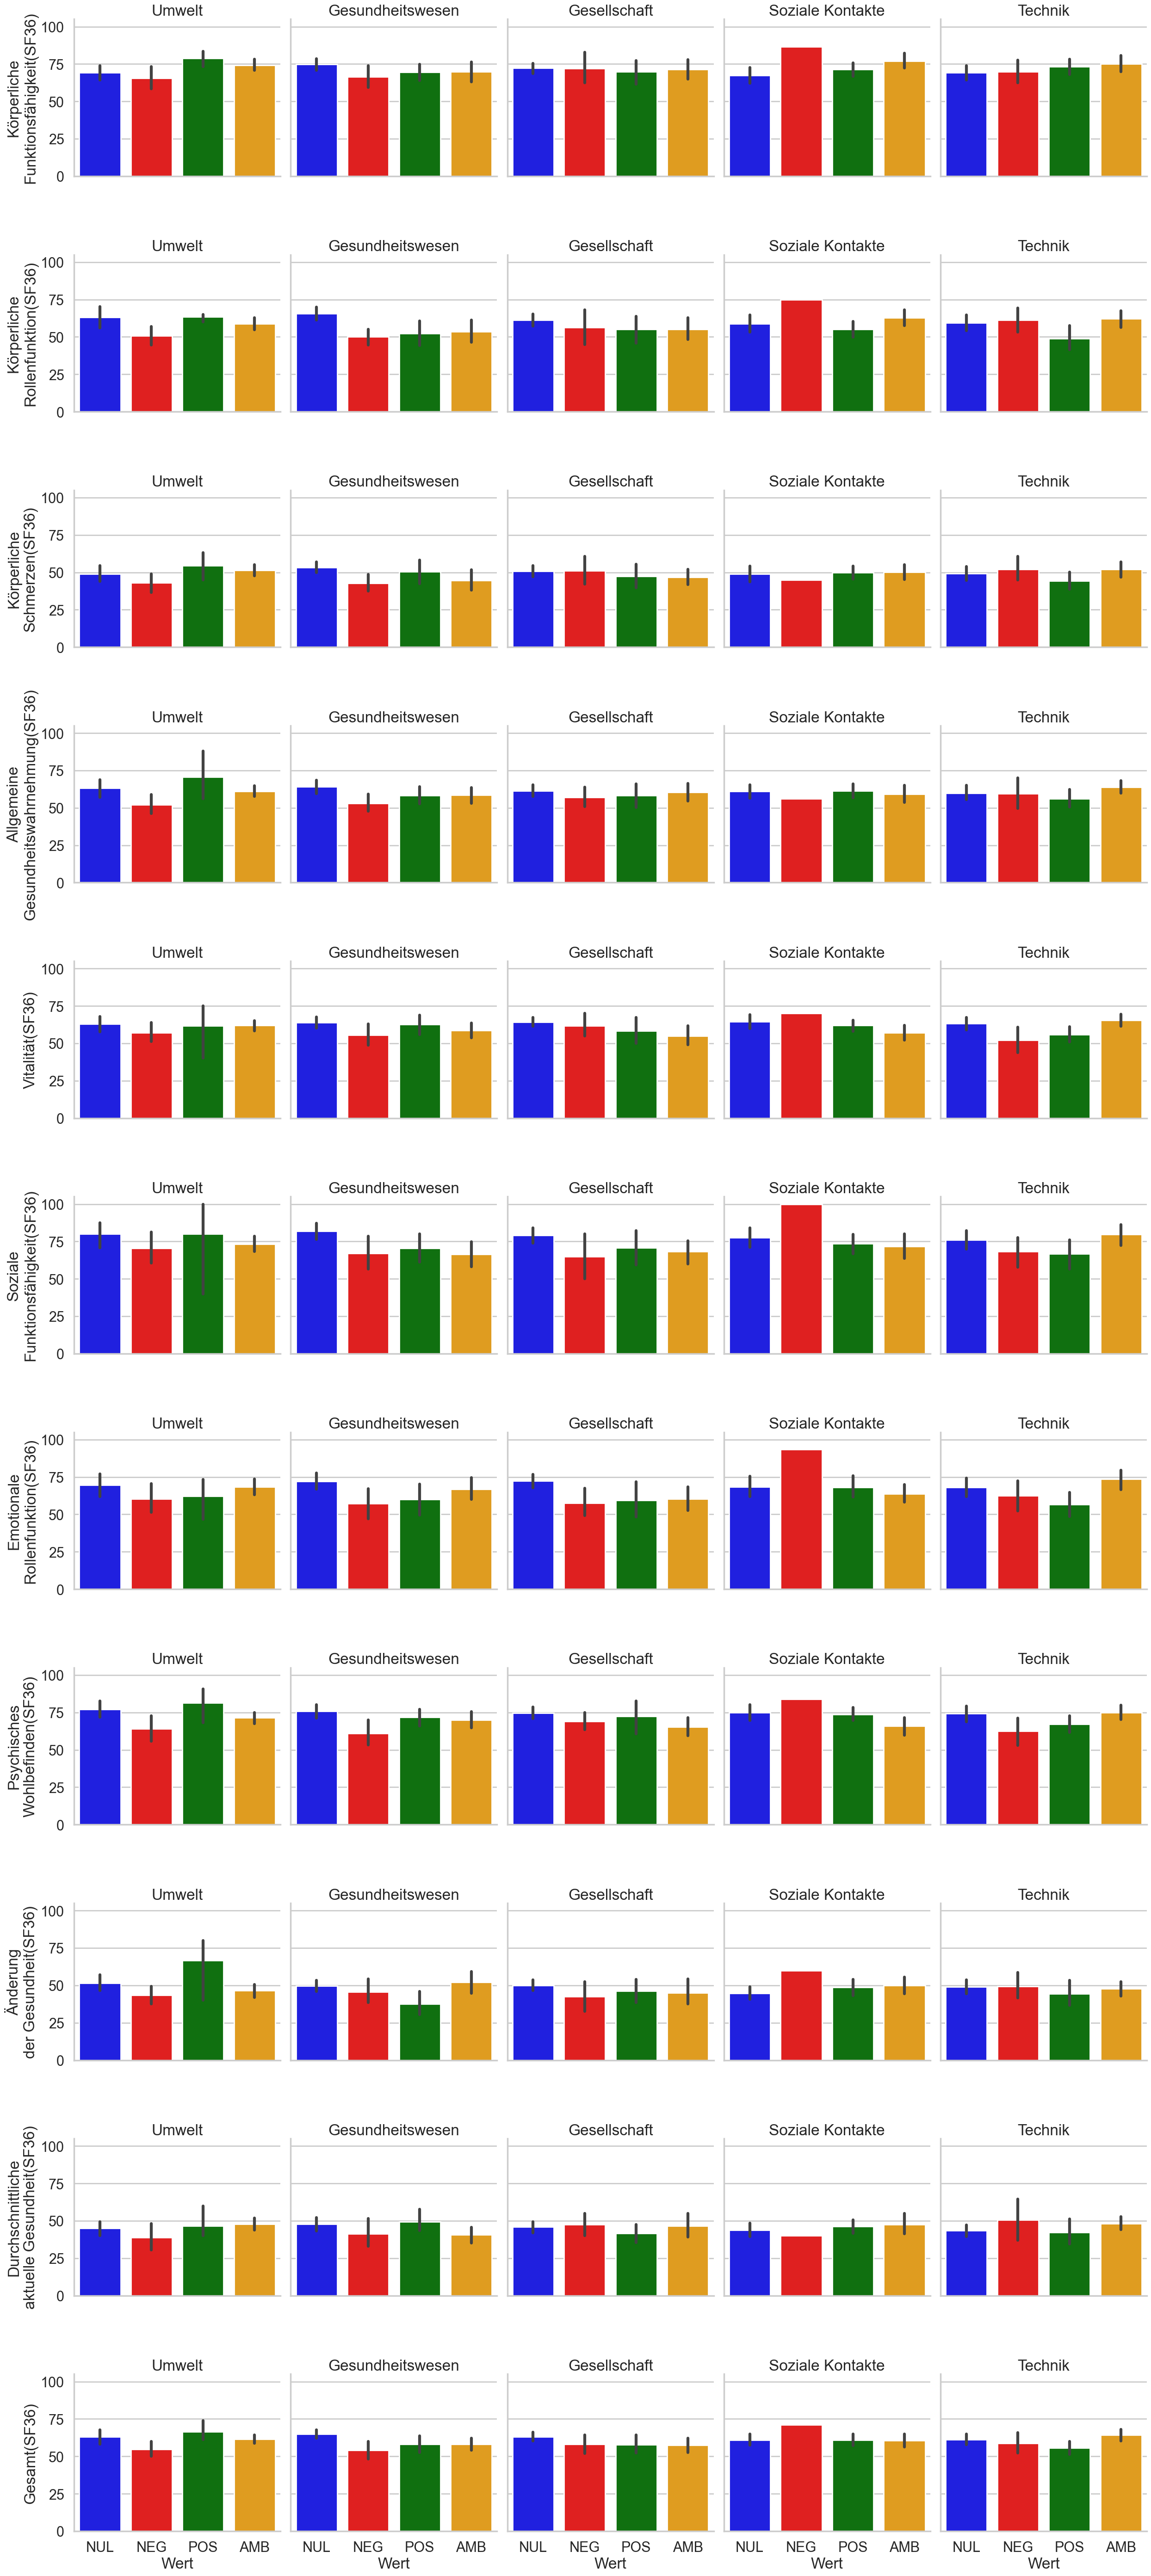

In [247]:
sns.set_context("poster")
palette = {
        'NUL': 'blue',
        'NEG': 'red',
        'POS': 'green',
        'AMB': 'orange'
    }
g=sns.catplot(df_env_sf36_l2, kind='bar', x='Wert', y='SF36 Score', row='SF36 Domain' , col='Bereich', order=['NUL','NEG','POS','AMB'], hue='Wert', palette=palette, legend=False)
sf36_headings=df_env_sf36_l2['SF36 Domain'].unique()
bereich_headings=df_env_sf36_l2['Bereich'].unique()
for i,ax in enumerate(g.axes):
    ax[0].set_ylabel(sf36_headings[i])
    # make line breaks in the ylabel if too long
    if len(sf36_headings[i])>20:
        parts = sf36_headings[i].split(' ')
        mid = len(parts)//2
        new_label = ' '.join(parts[:mid]) + '\n' + ' '.join(parts[mid:])
        ax[0].set_ylabel(new_label)
    # now make individual titles for columns
    for j in range(len(ax)):
        ax[j].set_title(bereich_headings[j])
# adjust layout


fig=g.fig
fig.subplots_adjust(bottom=0,hspace=0.5,wspace=0.05)
g.savefig('output/raupennest/env-sf36-v3.jpg', dpi=600)

In [248]:
# get statistics with means, std and p-values for each SF36 domain per ENV factor
sf36_env_stats = []
for bereich in df_env_enc.columns:
    for domain in df_sf36_grouped2.columns:
        df_subset = df_env_sf36_combined[[bereich, domain]].dropna()
        groups = df_subset.groupby(bereich)[domain]
        means = groups.mean()
        stds = groups.std()
        counts = groups.count()
        # perform ANOVA
        from scipy.stats import f_oneway
        group_values = [group[1].values for group in groups]
        f_stat, p_value = f_oneway(*group_values)
        sf36_env_stats.append({'Bereich':bereich, 'SF36 Domain':domain,
                                 'means':means.to_dict(),
                                 'stds':stds.to_dict(),
                                 'counts':counts.to_dict(),
                                 'p_value':p_value})
df_sf36_env_stats = pd.DataFrame(sf36_env_stats)
df_sf36_env_stats.to_excel('output/raupennest/sf36-env-statistics-v3.xlsx')
